# Step 1: Parsing Files, Adding Candidates and Labels to Database

In [1]:
from __future__ import print_function
from __future__ import division
import json
# Loading config
with open("run_config.json") as fl:
    cfg = json.load(fl)
cfg_params = cfg['parameters']

# Setting snorkel path and output root
import os
from os.path import join
output_root = join(cfg_params['output_path'],cfg_params['experiment_name'])
os.environ['FONDUERDBNAME'] = cfg['postgres_db_name']
os.environ['SNORKELDB'] = join(cfg['postgres_location'],os.environ['FONDUERDBNAME'])

# For loading input files
import pandas as pd

# For running Snorkel
from snorkel.contrib.fonduer import SnorkelSession
from snorkel.contrib.fonduer.models import candidate_subclass
from snorkel.contrib.fonduer import HTMLPreprocessor, OmniParser
from utils import HTMLListPreprocessor

from sqlalchemy import create_engine
snorkeldb = create_engine(os.environ['SNORKELDB'], isolation_level="AUTOCOMMIT")

In [2]:
# Load labeled data from tsv
# Creating path to labeled data
pth_labeled = join(cfg['data_path'],'labels_and_splits')
# Getting labele data file name
fl_labeled = cfg['labeled_data_file']
# Loading labeled data into dataframe
df_labeled = pd.read_csv(join(pth_labeled,fl_labeled),sep='\t')
# Adding .html to filenames
# NOTE: Need to add .html to all actual filenames before running
path_list_labeled = [_+'.html' for _ in df_labeled['file name'].tolist()]

#Load unlabeled data from tsv
fl_unlabeled = cfg['unlabeled_data_file']
df_unlabeled = pd.read_csv(join(pth_labeled,fl_unlabeled),sep='\t')
path_list_unlabeled = [_+'.html' for _ in df_unlabeled['file name'].tolist()]

# Start snorkel session and creating location subclass
session = SnorkelSession()
Location_Extraction = candidate_subclass('location_extraction',\
                          ["location"])

## Parsing Documents

In [3]:
# Getting parameter for max number of docs to load from labeled/unlabeled
max_docs = cfg['max_docs']

# Setting location for raw data
data_loc = join(cfg['data_path'],'raw_data')

# Creating a list of paths for documents from both labeled and unlabeled data
path_list = path_list_labeled[:max_docs]+path_list_unlabeled[:max_docs]

# Preprocessing documents from path_list
doc_preprocessor = HTMLListPreprocessor(data_loc,\
                                file_list=path_list)

# Ingest data into Fonduer via parser
corpus_parser = OmniParser(structural=True, lingual=True, visual=False)
%time corpus_parser.apply(doc_preprocessor, parallelism=cfg['parallel'])

Clearing existing...
Running UDF...


Warning, empty document 018563ac-eb50-4d26-8507-31e9cf836999 passed to CoreNLP

CPU times: user 560 ms, sys: 152 ms, total: 712 ms
Wall time: 54 s


In [4]:
from snorkel.contrib.fonduer.models import Document, Phrase

# Checking database contents
print("Documents:", session.query(Document).count())
print("Phrases:", session.query(Phrase).count())

('Documents:', 8L)
('Phrases:', 2388L)


# Step 2: Dividing into Test/Train, Extracting Features, Throttling

In [5]:
# Getting all documents parsed by Fonduer
docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

# Setting up train, dev, and test sets
train_docs = set()
dev_docs   = set()
test_docs  = set()

# Creating list of (document name, Fonduer document object) tuples
data = [(doc.name+'.html', doc) for doc in docs]
data.sort(key=lambda x: x[0])

# Adding unlabeled data to train set, 
# labaled data to dev/test sets in alternating fashion
for i, (doc_name, doc) in enumerate(data):
    if doc_name in path_list_unlabeled:
        train_docs.add(doc)
    else:
        if len(dev_docs)<=len(test_docs):
            dev_docs.add(doc)
        else:
            test_docs.add(doc)

#Printing length of train/test/dev sets
print("train:",len(train_docs))
print("dev:" ,len(dev_docs))
print("test:",len(test_docs))

#Printing some filenames 
from pprint import pprint
pprint([x.name for x in train_docs])
pprint([x.name for x in dev_docs])
pprint([x.name for x in test_docs])

('train:', 4)
('dev:', 2)
('test:', 2)
[u'001a5f8b-82c5-4428-b539-0c8a0f2f87c4',
 u'005dd27d-91c5-4569-b285-489391dcff4f',
 u'0069a7dd-9a03-4240-9073-77744c10b467',
 u'0034ff21-5d7a-4edf-9150-e22c5188dde1']
[u'018563ac-eb50-4d26-8507-31e9cf836999',
 u'0397de89-5130-4f56-8a46-3e533d393d8d']
[u'02ee12ba-0582-4a1f-9d54-0d59d683550f',
 u'03a826f2-4ae7-40de-a4f9-e01bf379df9d']


In [6]:
#Importing matchers module and defining LocationMatcher
from snorkel.matchers import *
location_matcher = LocationMatcher(longest_match_only=True) 

#importing NGrams and defining location_ngrams 
from snorkel.contrib.fonduer.fonduer.candidates import OmniNgrams
location_ngrams = OmniNgrams(n_max=6, split_tokens=[])

In [7]:
from snorkel.contrib.fonduer.lf_helpers import *
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# Creating filter to eliminate mentions of currency  
def location_currencies_filter(location):
    list_currencies = [ "dollar", "dollars", "lira","kwacha","rials","rial","dong","dongs","fuerte","euro",
                       "euros","vatu","som","peso","sterling","sterlings","soms","pestos",
                       "pounds", 
                  "pound","dirham","dirhams","hryvnia","manat","manats","liras","lira",
                       "dinar","dinars","pa'anga","franc","baht","schilling",
                  "somoni","krona","lilangeni","rupee","rand","shilling","leone","riyal","dobra",
                  "tala","ruble","zloty","peso","sol","quarani","kina","guinean","balboa","krone","naira",
                  "cordoba","kyat","metical","togrog","leu","ouguiya","rufiyaa","ringgit","kwacha",
                  "ariary","denar","litas","loti","lats","kip","som","won","tenge","yen","shekel","rupiah",
                  "forint","lempira","gourde","quetzal","cedi","lari","dalasi","cfp","birr","kroon","nakfa",
                  "cfa","Peso","koruna","croatian","colon","yuan","escudo","cape","riel","lev","real"
                  ,"real","mark","boliviano","ngultrum","taka","manat","dram","kwanza","lek","afghani","renminbi"]

    
    cand_right_tokens = list(get_right_ngrams(location,window=2))
    for cand in cand_right_tokens:
        if cand not in list_currencies:
            return location

# Setting candidate filter to location_currencies_filter
candidate_filter = location_currencies_filter

/lfs/local/0/jdunnmon/repos/anaconda3/envs/py27snorkel/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
from snorkel.contrib.fonduer.candidates import CandidateExtractor

# Defining candidate extractor
candidate_extractor = CandidateExtractor(Location_Extraction,
                                         [location_ngrams], [location_matcher],
                                         candidate_filter=candidate_filter)

# Extracting candidates from each split
%time candidate_extractor.apply(train_docs, split=0, parallelism=cfg['parallel'])
print("Number of candidates:", session.query(Location_Extraction).filter(Location_Extraction.split == i+1).count())
%time
for i, docs in enumerate([dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i+1, parallelism=cfg['parallel'])
    print("Number of candidates:", session.query(Location_Extraction).filter(Location_Extraction.split == i+1).count())

Clearing existing...
Running UDF...
CPU times: user 44 ms, sys: 216 ms, total: 260 ms
Wall time: 4.03 s
('Number of candidates:', 0L)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.9 µs
Clearing existing...
Running UDF...
('Number of candidates:', 26L)
Clearing existing...
Running UDF...
('Number of candidates:', 12L)


In [9]:
# Testing sandbox for candiates
ind = 1
cands = session.query(Location_Extraction).filter(Location_Extraction.split == 1).order_by(Location_Extraction.id).all()
cand = cands[ind]
args = cand.get_contexts()
span = args[0]
c = span.sentence.is_lingual()
a = span.get_parent()
print(span)
print(cand[0].sentence.document.name)
print(cand[0].get_span())
print('>' in cand[0].get_parent().text)

Span("Dallas", sentence=44483, chars=[0,5], words=[0,0])
0397de89-5130-4f56-8a46-3e533d393d8d
Dallas
False


In [10]:
# Applying the featurizer (to get feature vector describing the input)
from snorkel.contrib.fonduer import BatchFeatureAnnotator
featurizer = BatchFeatureAnnotator(Location_Extraction)
# Running for train set -- replace_key_set = True!
%time F_train = featurizer.apply(split=0, replace_key_set=True, parallelism=cfg['parallel'])
print(F_train.shape)
# Running for dev set -- replace_key_set = False! Uses same featuers as dev set
%time F_dev = featurizer.apply(split=1, replace_key_set=False, parallelism=cfg['parallel'])
print(F_dev.shape)
%time F_test = featurizer.apply(split=2, replace_key_set=False, parallelism=cfg['parallel'])
print(F_test.shape)

Clearing existing...
Running UDF...
Copying location_extraction_feature_updates to postgres
COPY 9

CPU times: user 44 ms, sys: 212 ms, total: 256 ms
Wall time: 4.02 s
(9, 463)
Clearing existing...
Running UDF...


Process BatchAnnotatorUDF-81:
Traceback (most recent call last):
  File "/lfs/local/0/jdunnmon/repos/anaconda3/envs/py27snorkel/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/snorkel/udf.py", line 161, in run
    for y in self.apply(x, **self.apply_kwargs):
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/snorkel/contrib/fonduer/fonduer/async_annotations.py", line 215, in apply
    for id, k, v in self.anno_generator(list(candidates)):
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/snorkel/contrib/fonduer/fonduer/features/features.py", line 11, in get_all_feats
    for id, f, v in get_content_feats(candidates):
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/snorkel/contrib/fonduer/fonduer/features/content_features.py", line 46, in get_content_feats
    xmltree = corenlp_to_xmltree(sent)
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 87, in corenlp_to_xmltree
    root = corenlp_to_xmlt

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_xmltree_sub(s, dep_parents, i+1))
  File "/lfs/raiders2/0/jdunnmon/chtap/snorkel/tree_structs.py", line 122, in corenlp_to_xmltree_sub
    root.append(corenlp_to_x

Copying location_extraction_feature_updates to postgres
COPY 0

CPU times: user 796 ms, sys: 524 ms, total: 1.32 s
Wall time: 3.65 s
(26, 463)
Clearing existing...
Running UDF...
Copying location_extraction_feature_updates to postgres
COPY 12

CPU times: user 60 ms, sys: 136 ms, total: 196 ms
Wall time: 3.68 s
(12, 463)


# Step 3: Adding Gold Labels

In [11]:
from builtins import range
import csv
import codecs

from snorkel.utils import ProgressBar
from snorkel.models import GoldLabel, GoldLabelKey

# Defining function for getting gold labels
# Could go in utils file later!
def load_chtap_labels(session, candidate_class, df, target, annotator_name='gold'):
    
    # Database nonsense to make sure that there is a "gold" annotator 
    ak = session.query(GoldLabelKey).filter(GoldLabelKey.name == annotator_name).first()
    if ak is None:
        ak = GoldLabelKey(name=annotator_name)
        session.add(ak)
        session.commit()   
    
    # Getting all candidates from dev/test set only (splits 1 and 2)
    candidates = session.query(candidate_class).filter(candidate_class.split != 0).all()
    cand_total = len(candidates)
    print('Loading', cand_total, 'candidate labels')
    pb = ProgressBar(cand_total)
    labels=[]
    
    # For each candidate, add appropriate gold label
    for i, c in enumerate(candidates):
        pb.bar(i)
        # Get document name for candidate
        doc = c[0].sentence.document.name
        # Get text span for candidate
        val = c[0].get_span().lower()
        # Get location label from labeled dataframe (input)
        target_strings = df[df['file name']==doc][target].tolist()
        # Handling location extraction
        if target == 'location':
                if target_strings == []:
                    targets = ''
                else:
                    targets = target_strings[0].lower().split(',')
        # Keeping this in comments...don't know what it was for
        #context_stable_ids = '~~'.join([i.stable_id for i in c.get_contexts()])
        label = session.query(GoldLabel).filter(GoldLabel.key == ak).filter(GoldLabel.candidate == c).first()
        if label is None:
            # Matching target label string to extract span, adding TRUE label if found, FALSE if not
            # This conditional could be improved (use regex, etc.)
            if val in targets or any([a in val for a in targets]):
                label = GoldLabel(candidate=c, key=ak, value=1)
            else:
                label = GoldLabel(candidate=c, key=ak, value=-1)
            session.add(label)
            labels.append(label)
    session.commit()
    pb.close()

    session.commit()
    print("AnnotatorLabels created: %s" % (len(labels),))

In [12]:
# Adding gold labels to database
session.rollback()
target = 'location'
load_chtap_labels(session, Location_Extraction, df_labeled, target ,annotator_name='gold')

Loading 38 candidate labels
[========================================] 100%
AnnotatorLabels created: 38


# Step 4: Creating LFs

In [42]:
# Helper functions for true/false/abstain
TRUE,FALSE,ABSTAIN = 1,-1,0

In [14]:
# API function sandbox
from snorkel.contrib.fonduer.lf_helpers import *
get_ancestor_tag_names(cands[5])

['html', 'head', 'script']

In [15]:
from snorkel.contrib.fonduer.lf_helpers import *

# Defining LFs
# LF API is here: http://web.stanford.edu/~lwhsiao/api/

def LF_in_breadcrumbs(c):
    parent_text = c[0].get_parent().text
    return TRUE if '>' in parent_text else ABSTAIN

def LF_head_in_tag(c):
    tags = get_ancestor_tag_names(c[0])
    return FALSE if 'head' in tags else TRUE

def LF_body_in_tag(c):
    tags = get_ancestor_tag_names(c[0])
    return TRUE if 'body' in tags else FALSE

# Need more of these...can check tutorials for inspiration

In [16]:
# Collect LFs in list
lfs_location = [LF_in_breadcrumbs, LF_head_in_tag, LF_body_in_tag]

# Step 5: Running Generative Model

In [33]:
from snorkel.contrib.fonduer import BatchLabelAnnotator

# Annotating candidats using LFs (clear=True replaced existing)
labeler = BatchLabelAnnotator(Location_Extraction, lfs=lfs_location)
%time L_train = labeler.apply(split=0, clear=True, parallelism=cfg['parallel'])
%time L_dev = labeler.apply(split=1, clear=True, parallelism=cfg['parallel'])
%time L_test = labeler.apply(split=2, clear=True, parallelism=cfg['parallel'])
print(L_dev.shape)

Clearing existing...
Running UDF...
Copying location_extraction_label_updates to postgres
COPY 9

CPU times: user 40 ms, sys: 212 ms, total: 252 ms
Wall time: 3.46 s
Clearing existing...
Running UDF...
Copying location_extraction_label_updates to postgres
COPY 26

CPU times: user 28 ms, sys: 168 ms, total: 196 ms
Wall time: 3.56 s
Clearing existing...
Running UDF...
Copying location_extraction_label_updates to postgres
COPY 12

CPU times: user 48 ms, sys: 148 ms, total: 196 ms
Wall time: 3.42 s
(26, 3)


In [27]:
# Showing a candidate from dev set
L_dev.get_candidate(session, 1)

location_extraction(Span("Dallas", sentence=44483, chars=[0,5], words=[0,0]))

In [29]:
# Loading assessing LF performance vs. gold labels
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
%time L_dev.lf_stats(L_gold_dev)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 16.2 ms


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_in_breadcrumbs,0,0.576923,0.576923,0.5,1,14,0,0,0.066667
LF_head_in_tag,1,1.000000,1.000000,0.5,9,4,0,13,0.846154
LF_body_in_tag,2,1.000000,1.000000,0.5,9,4,0,13,0.846154


In [32]:
from snorkel.learning import GenerativeModel

# Running the generative model
# TODO: Add hyperparameter search 
gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)

Inferred cardinality: 2
CPU times: user 88 ms, sys: 4 ms, total: 92 ms
Wall time: 137 ms


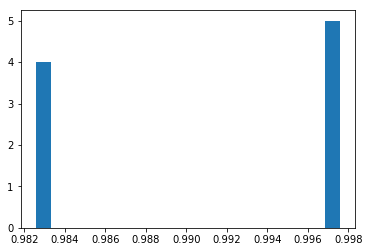

In [34]:
# Importing and plotting training marginals
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [36]:
# Printing LF accuracies
gen_model.weights.lf_accuracy

array([1.00009221, 1.00734263, 1.00873614])

In [38]:
# Pringint LF stats post-learning
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
prec, rec, f1 = gen_model.score(L_dev, L_gold_dev)
L_dev.lf_stats(L_gold_dev, gen_model.weights.lf_accuracy)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_in_breadcrumbs,0,0.576923,0.576923,0.5,1,14,0,0,0.066667,1.000092
LF_head_in_tag,1,1.000000,1.000000,0.5,9,4,0,13,0.846154,1.007343
LF_body_in_tag,2,1.000000,1.000000,0.5,9,4,0,13,0.846154,1.008736


In [39]:
from snorkel.learning import SparseLogisticRegression
# Running discriminative model to predict generative model marginals from 
# features output from featurizer
disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=9  #epochs=200  batch size=9
[SparseLogisticRegression] Epoch 0 (0.15s)	Average loss=0.818175
[SparseLogisticRegression] Epoch 5 (0.17s)	Average loss=0.712246
[SparseLogisticRegression] Epoch 10 (0.19s)	Average loss=0.619761
[SparseLogisticRegression] Epoch 15 (0.21s)	Average loss=0.540357
[SparseLogisticRegression] Epoch 20 (0.23s)	Average loss=0.472992
[SparseLogisticRegression] Epoch 25 (0.25s)	Average loss=0.416229
[SparseLogisticRegression] Epoch 30 (0.27s)	Average loss=0.368509
[SparseLogisticRegression] Epoch 35 (0.29s)	Average loss=0.328348
[SparseLogisticRegression] Epoch 40 (0.31s)	Average loss=0.294438
[SparseLogisticRegression] Epoch 45 (0.32s)	Average loss=0.265679
[SparseLogisticRegression] Epoch 50 (0.34s)	Average loss=0.241166
[SparseLogisticRegression] Epoch 55 (0.36s)	Average loss=0.220166
[SparseLogisticRegression] Epoch 60 (0.38s)	Average loss=0.202084
[SparseLogisticRegression] Epoch 65 (0

In [40]:
# Evaluate discriminative on test set 
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [41]:
# Get candidates, discriminative model outputs, and discriminative model predicts
test_candidates = [F_test.get_candidate(session, i) for i in range(F_test.shape[0])]
test_score = disc_model.predictions(F_test)
true_pred = [test_candidates[_] for _ in np.nditer(np.where(test_score > 0))]

In [ ]:
# EVALUATE F1 ETC...TBD